In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")

In [2]:
class SOBacktester(): 
    ''' Class for the vectorized backtesting of SO-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    periods: int
        time window in days for rolling low/high
    D_mw: int
        time window in days for %D line
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets one or two new SO parameters
        
    test_strategy:
        runs the backtest for the SO-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates SO parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two SO parameters
    '''
    
    def __init__(self, symbol, periods, D_mw, start, end, tc):
        self.symbol = symbol
        self.periods = periods
        self.D_mw = D_mw
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "SOBacktester(symbol = {}, periods = {}, D_mw = {}, start = {}, end = {})".format(self.symbol, self.periods, self.D_mw, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("{}_ohlc.csv".format(self.symbol), parse_dates = [0], index_col = 0)
        raw = raw.dropna()
        raw = raw.loc[self.start:self.end]
        raw["returns"] = np.log(raw.Close / raw.Close.shift(1))
        raw["roll_low"] = raw.Low.rolling(self.periods).min()
        raw["roll_high"] = raw.High.rolling(self.periods).max()
        raw["K"] = (raw.Close - raw.roll_low) / (raw.roll_high - raw.roll_low) * 100
        raw["D"] = raw.K.rolling(self.D_mw).mean()
        self.data = raw
        
    def set_parameters(self, periods = None, D_mw = None):
        ''' Updates SO parameters and resp. time series.
        '''
        if periods is not None:
            self.periods = periods
            self.data["roll_low"] = self.data.Low.rolling(self.periods).min()
            self.data["roll_high"] = self.data.High.rolling(self.periods).max()
            self.data["K"] = (self.data.Close - self.data.roll_low) / (self.data.roll_high - self.data.roll_low) * 100
            self.data["D"] = self.data.K.rolling(self.D_mw).mean() 
        if D_mw is not None:
            self.D_mw = D_mw
            self.data["D"] = self.data.K.rolling(self.D_mw).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["K"] > data["D"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | periods = {}, D_mw = {} | TC = {}".format(self.symbol, self.periods, self.D_mw, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, SO):
        ''' Updates SO parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        SO: tuple
            SO parameter tuple
        '''
        self.set_parameters(int(SO[0]), int(SO[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, periods_range, D_mw_range):
        ''' Finds global maximum given the SO parameter ranges.

        Parameters
        ==========
        periods_range, D_mw_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (periods_range, D_mw_range), finish=None)
        return opt, -self.update_and_run(opt)
    
    

In [8]:
tester = SOBacktester("EURUSD", 14, 3, "2008-01-01", "2020-12-31", 0.00007)

In [9]:
tester

SOBacktester(symbol = EURUSD, periods = 14, D_mw = 3, start = 2008-01-01, end = 2020-12-31)

In [10]:
tester.test_strategy()

(1.095138, 0.258653)

In [11]:
tester.results

,Open,High,Low,Close,returns,roll_low,roll_high,K,D,position,strategy,trades,creturns,cstrategy
2008-01-20,1.46040,1.46046,1.44218,1.44544,-0.010262,1.44218,1.49224,6.512185,6.728020,-1,0.010262,0.0,0.989790,1.010315
2008-01-21,1.44538,1.46434,1.43664,1.46294,0.012034,1.43664,1.49224,47.302158,19.330342,1,-0.012174,2.0,1.001774,0.998090
2008-01-22,1.46292,1.46844,1.45114,1.46304,0.000068,1.43664,1.49224,47.482014,33.765453,1,0.000068,0.0,1.001842,0.998158
2008-01-23,1.46298,1.47794,1.45912,1.47556,0.008521,1.43664,1.49224,70.000000,54.928058,1,0.008521,0.0,1.010415,1.006700
2008-01-24,1.47546,1.47778,1.46610,1.46813,-0.005048,1.43664,1.49224,56.636691,58.039568,-1,-0.005188,2.0,1.005327,1.001491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,1.21873,1.22158,1.21774,1.21849,-0.000057,1.20588,1.22728,58.925234,55.623053,1,-0.000083,2.0,0.834382,1.092538
2020-12-27,1.21892,1.22504,1.21812,1.22152,0.002484,1.20588,1.22728,73.084112,63.753894,1,0.002484,0.0,0.836457,1.095255
2020-12-28,1.22145,1.22752,1.22086,1.22502,0.002861,1.20588,1.22752,88.447320,73.485555,1,0.002861,0.0,0.838854,1.098393
2020-12-29,1.22508,1.23102,1.22495,1.23000,0.004057,1.20754,1.23102,95.655877,85.729103,1,0.004057,0.0,0.842264,1.102859


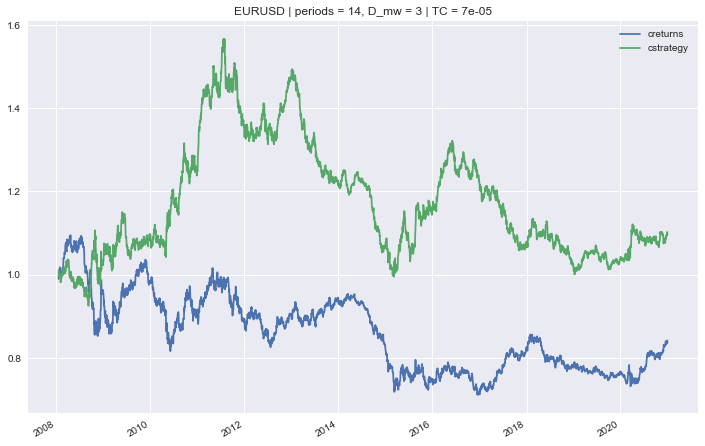

In [12]:
tester.plot_results()

In [13]:
tester.optimize_parameters((10, 100, 1), (3, 50, 1))

(array([27., 11.]), 1.584622)

In [14]:
tester.test_strategy()

(1.584622, 0.74641)

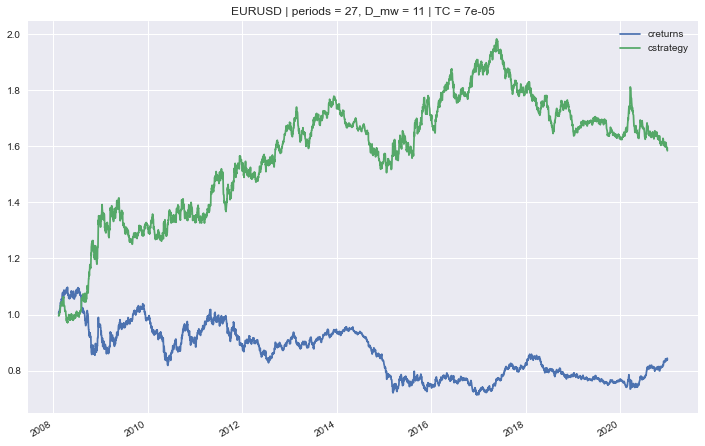

In [15]:
tester.plot_results()